# Принятие решений в бизнесе

Отдел маркетинга крупного интернет-магазина совместно с аналитиком подготовили список гипотез для увеличения выручки.

Цели исследования:
- приоритизировать гипотезы
- запустить A/B-тест
- проанализировать результаты A/B-теста. 

## Описание данных

Файл `/datasets/hypothesis.csv`:

- `Hypothesis` — краткое описание гипотезы
- `Reach` — охват пользователей по 10-балльной шкале
- `Impact` — влияние на пользователей по 10-балльной шкале
- `Confidence` — уверенность в гипотезе по 10-балльной шкале
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл `/datasets/orders.csv`:

- `transactionId` — идентификатор заказа
- `visitorId` — идентификатор пользователя, совершившего заказ
- `date` — дата, когда был совершён заказ
- `revenue` — выручка заказа
- `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`:

- `date` — дата
- `group` — группа A/B-теста
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

## Предобработка данных

In [1]:
# импорт библиотек
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [2]:
try:
    hypothesis = pd.read_csv('hypothesis.csv')
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
# вывод первых строк для ознакомления
display(hypothesis.head())
display(orders.head())
display(visitors.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [3]:
# приведём названия столбцов датафреймов к стандартному виду
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

Выведем общую информацию о датафреймах:

In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Пропуски отсутствуют. Необходимо привести тип данных столбцов `date` в датафреймах `orders` и `visitors` к формату `datetime`.

In [7]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Проверим датафреймы на наличие дубликатов:

In [8]:
hypothesis.duplicated().sum()

0

In [9]:
orders.duplicated().sum()

0

In [10]:
visitors.duplicated().sum()

0

Явные дубликаты отсутствуют.

Проверим количество тестируемых групп.

In [11]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [12]:
visitors['group'].unique()

array(['A', 'B'], dtype=object)

Как и заявлено, тестировались две группы A и B.

Узнаем, в какой период проводилось тестирование.

In [13]:
orders['date'].min()

Timestamp('2019-08-01 00:00:00')

In [14]:
orders['date'].max()

Timestamp('2019-08-31 00:00:00')

In [15]:
visitors['date'].min()

Timestamp('2019-08-01 00:00:00')

In [16]:
visitors['date'].max()

Timestamp('2019-08-31 00:00:00')

Тестирование проводилось в период с 1-ого по 31-ое августа 2019 года.

Проверим, не попали ли одни и те же пользователи в обе группы.

In [17]:
# для каждого пользователя посчитаем количество уникальных групп
# пользователей с двумя группами занесём в отдельную переменную
visitorsAB = orders.groupby('visitor_id').agg({'group': 'nunique'}).query('group == 2')
visitorsAB.count()

group    58
dtype: int64

Имеются 58 пользователей, которые попали в обе группы. Узнаем, какой процент от общего числа пользователей они составляют.

In [18]:
visitorsAB.shape[0] / orders['visitor_id'].nunique() * 100

5.625606207565471

Оставим эти 5.6% дублированных пользователей, так как мы можем исключить их только из таблицы `orders`, а в таблице `visitors` нет данных о том, какие пользователи посещали интренет-магазин в определённые даты.

Проверим данные о стоимости заказов и ежедневных посетителях по группам по критерию Шапиро-Уилка. За нулевую гипотезу примем, что данные нормальны.


In [19]:
# проверка данных о стоимости заказов в группе A на нормальность
alpha = 0.05

results = stats.shapiro(orders[orders['group'] == 'A']['revenue'])
p_value = results[1]

display('p-значение: {0:.40f}'.format(p_value))

if p_value < alpha:
    display('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    display('Не получилось отвергнуть нулевую гипотезу, распределение нормально') 

'p-значение: 0.0000000000000000000000000000000001739724'

'Отвергаем нулевую гипотезу: распределение не нормально'

In [20]:
# проверка данных о стоимости заказов в группе B на нормальность
alpha = 0.05

results = stats.shapiro(orders[orders['group'] == 'B']['revenue'])
p_value = results[1]

display('p-значение: {0:.40f}'.format(p_value))

if p_value < alpha:
    display('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    display('Не получилось отвергнуть нулевую гипотезу, распределение нормально') 

'p-значение: 0.0000000000000000000000000000000000000000'

'Отвергаем нулевую гипотезу: распределение не нормально'

In [21]:
# проверка данных о ежедневном количестве посетителей в группе A на нормальность
alpha = 0.05

results = stats.shapiro(visitors[visitors['group'] == 'A']['visitors'])
p_value = results[1]

display('p-значение: {0:.5f}'.format(p_value))

if p_value < alpha:
    display('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    display('Не получилось отвергнуть нулевую гипотезу, распределение нормально') 

'p-значение: 0.02920'

'Отвергаем нулевую гипотезу: распределение не нормально'

In [22]:
# проверка данных о ежедневном количестве посетителей в группе B на нормальность
alpha = 0.05

results = stats.shapiro(visitors[visitors['group'] == 'B']['visitors'])
p_value = results[1]

display('p-значение: {0:.5f}'.format(p_value))

if p_value < alpha:
    display('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    display('Не получилось отвергнуть нулевую гипотезу, распределение нормально') 

'p-значение: 0.03645'

'Отвергаем нулевую гипотезу: распределение не нормально'

Как и следовало ожидать, распределение реальных данных не нормально. Это говорит о наличии аномалий, которые будут рассмотрены позднее.

## Приоритизация гипотез

Применим фреймворк `ICE` для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [23]:
# строка для полного отображения гипотез
pd.options.display.max_colwidth = 120
hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)
hypothesis[['hypothesis', 'ICE']].sort_values('ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Явным лидером по приоритетам `ICE` становится гипотеза 8. Данная гипотеза предполагает, что скидка на товар в день рождения пользователя увеличит выручку магазина.

Применим фреймворк `RICE` для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [24]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values('RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Явным лидером по приоритетам `RICE` становится гипотезы 7. Данная гипотеза предполагает, что форма подписки на основные страницы позволит собрать базу клиентов для e-mail рассылок, в следствие чего увеличится количество заказов и выручка.

На первое место вышла гипотеза 7, так как в методе `RICE` учитывается охват пользователей `reach`, которых затронут изменения. В данном случае у гипотезы 7 максимальный охват - 10 баллов, поэтому она наиболее важна, а изменения по гипотезе 8 затронут минимальное количество пользователей - 1 балл.

## Анализ A/B-теста

Мы провели A/B-тест и получили результаты, которые описаны в датафреймах `orders` и `visitors`.

In [25]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [26]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


### Кумулятивная выручка по группам

Построим график кумулятивной выручки по группам.

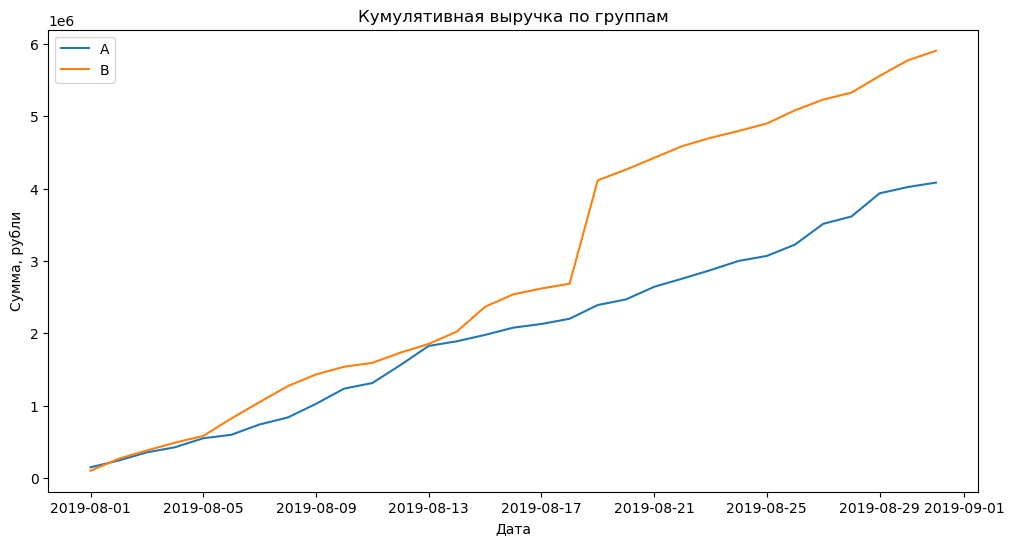

In [27]:
# создадим датафрейм datesGroups с уникальными парами значений 'date' и 'group' таблицы orders
# избавимся от дубликатов методом drop_duplicates()
datesGroups = orders[['date', 'group']].drop_duplicates()

# соберём агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1
).sort_values(by=['date', 'group'])

# соберём агрегированные кумулятивные по дням данные о посетителях
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1
).sort_values(by=['date', 'group'])

# объединим обе таблицы в одну с понятными названиями столбцов
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors'
]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12, 6))
# график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма, рубли')
plt.legend();

**Вывод:**
Кумулятивная выручка группы A плавно растёт на протяжении всего теста. Кумулятивная выручка группы B явно лидирует с 13 августа. 19 августа произошёл резкий рост - скорее всего в этот день были крупные заказы в группе B, далее идёт плавный рост.

### Кумулятивный средний чек по группам

Построим график кумулятивного среднего чека по группам.

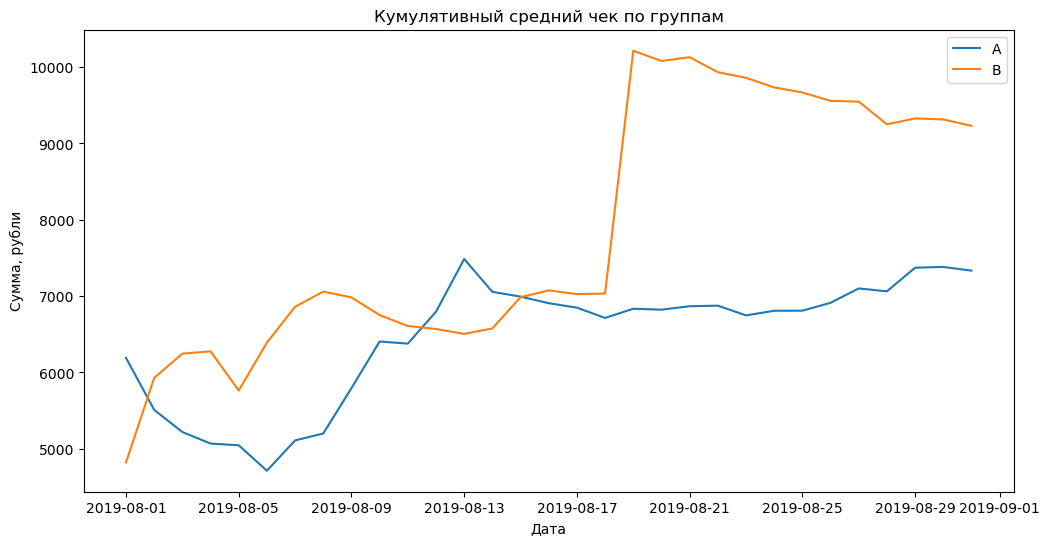

In [28]:
# средний чек = кумулятивная выручка / кумулятивное число заказов
plt.figure(figsize=(12, 6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма, рубли')
plt.legend();

**Вывод:**
Кумулятивный средний чек групп колеблется. В группе A после 13 августа размер среднего чека выровнялся. Виден явный всплеск 19 августа в группе B, после которого средний чек постепенно снижается. Имеется влияние аномальных значений.

### Относительное различие кумулятивного среднего чека

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

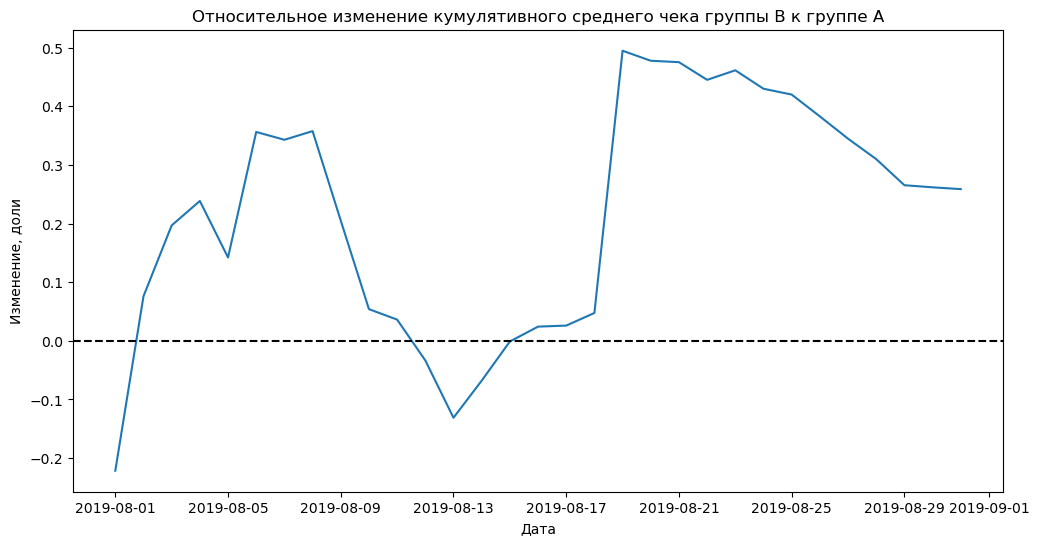

In [29]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, 
    left_on='date', 
    right_on='date', 
    how='left',
    suffixes=['A', 'B']
)

# cтроим отношение средних чеков
plt.figure(figsize=(12, 6))
plt.plot(
    mergedCumulativeRevenue['date'], 
    (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
    (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1
)

# добавляем горизонтальную ось y = 0
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменение, доли');

**Вывод:**
В некоторые дни график относительного различия кумулятивного чека резко скачет - в эти дни явно были совершены аномальные заказы в группах.

###  Кумулятивное среднее количество заказов на посетителя по группам

Построим график кумулятивного среднего количества заказов на посетителя по группам.

In [30]:
# найдём минимальную и максимальную дату для масштабирования графика
first_date = cumulativeData['date'].min()
last_date = cumulativeData['date'].max()

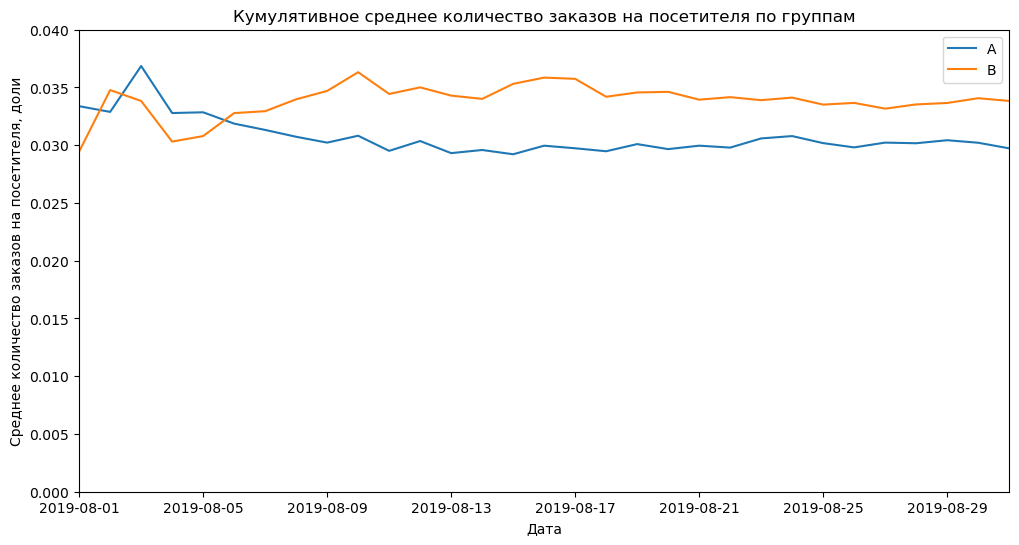

In [31]:
# считаем кумулятивное среднее количество заказов на посетителя по группам = число заказов / число посетителей
cumulativeData['orders_mean'] = cumulativeData['orders']/cumulativeData['visitors']

# выделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# выделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(12, 6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['orders_mean'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['orders_mean'], label='B')
plt.legend()
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов на посетителя, доли')

# задаем масштаб осей
plt.axis([first_date, last_date, 0, 0.04]);

**Вывод:**
В начале теста наблюдается колебание средних количеств заказов на посетителя обеих групп. К конце теста средние выровнялись и группа B вырвалась вперёд.

### Относительное различие кумулятивного среднего количества заказов на посетителя

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

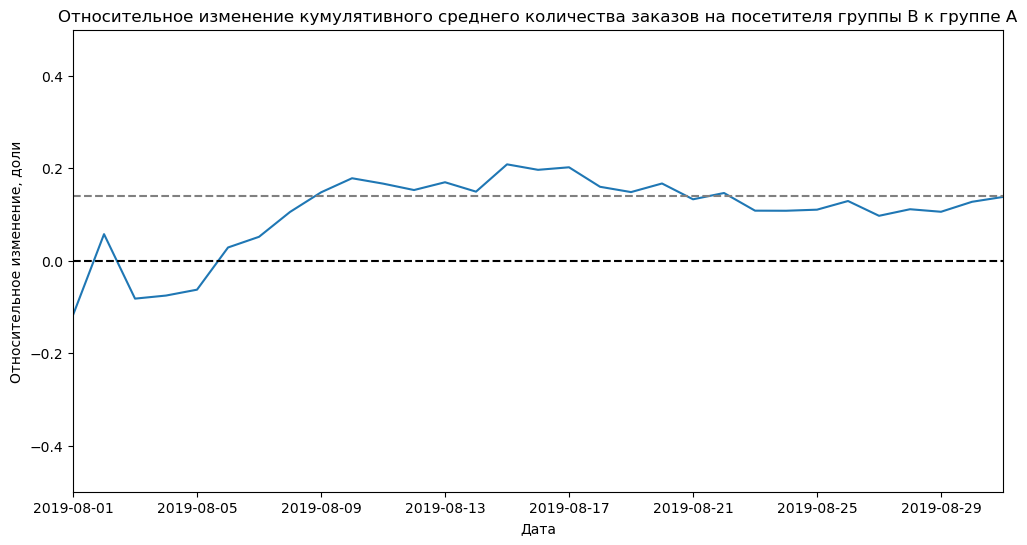

In [32]:
# собираем данные в одном датафрейме
mergedCumulativeOrdersMean = cumulativeDataA[['date','orders_mean']].merge(
    cumulativeDataB[['date','orders_mean']], left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

# cтроим отношение кумулятивных средних количеств заказов на посетителя группы B к группе A
plt.figure(figsize=(12, 6))
plt.plot(
    mergedCumulativeOrdersMean['date'], 
    mergedCumulativeOrdersMean['orders_meanB']/mergedCumulativeOrdersMean['orders_meanA']-1
)
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение, доли')
# добавляем горизонтальные оси y = 0 и y = 0.14
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--')
# задаем масштаб осей
plt.axis([first_date, last_date, -0.5, 0.5]);

**Вывод:**
Почти с начала проведения теста кумулятивное среднее количество заказов на посетителя группы B вырвалось вперёд и в середине относительный прирост достигал 20%. К концу теста прирост выровнялся на уровне примерно 14% и имеет тенденцию к росту.

### Точечный график количества заказов по пользователям

Построим точечный график количества заказов по пользователям.

In [33]:
# находим число заказов по пользователям
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


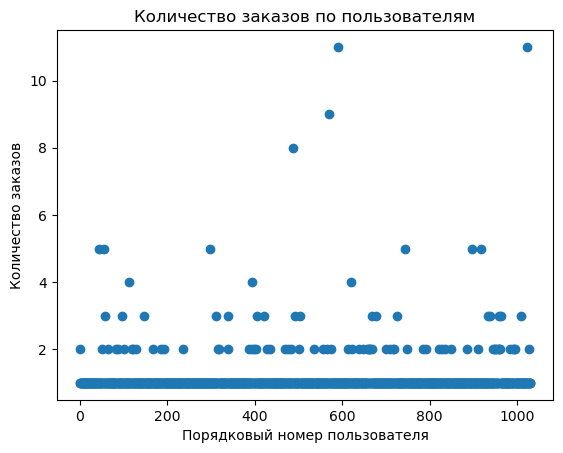

In [34]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
# строим точечный график количества заказов по пользователям
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Количество заказов по пользователям')
plt.xlabel('Порядковый номер пользователя')
plt.ylabel('Количество заказов');

**Вывод:**
Наибольшее количество заказов на пользователя - 11 заказов.

Присутствуют аномальные значения - больше двух заказов на пользователя выглядят выбросами на графике.

### 95-й и 99-й перцентили количества заказов на пользователя

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [35]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершили больше двух заказов, не более 1% - больше четырёх заказов.

Обозначим 4 заказа на пользователя как границу определения аномальных пользователей.

In [36]:
ordersByUsers_limit = np.percentile(ordersByUsers['orders'], [95, 99])[1]

### Точечный график стоимостей заказов

Построим точечный график стоимостей заказов.

In [37]:
orders.sort_values(by='revenue', ascending=False).head(10)

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
682,1216533772,4266935830,2019-08-29,78990,B
662,1811671147,4266935830,2019-08-29,78990,A
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A


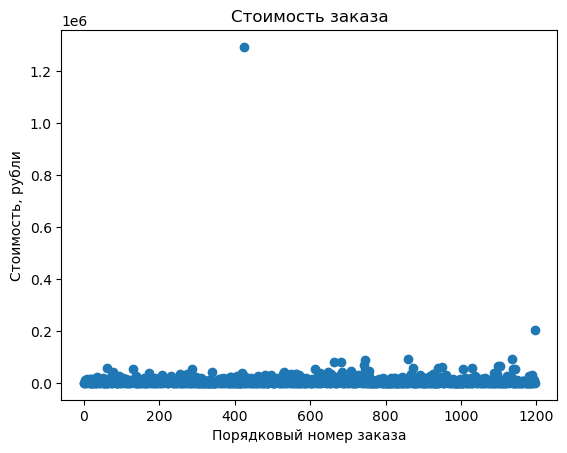

In [38]:
# серия из чисел от 0 до количества наблюдений в orders['revenue']
x_values = pd.Series(range(0, len(orders['revenue'])))
# строим точечный график стоимостей заказов
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказа')
plt.xlabel('Порядковый номер заказа')
plt.ylabel('Стоимость, рубли');

На графике видно 2 выброса - заказы стоимостью 1294500 и 202740 рублей.

Срежем эти заказы, чтобы лучше видеть распределение основной части данных.

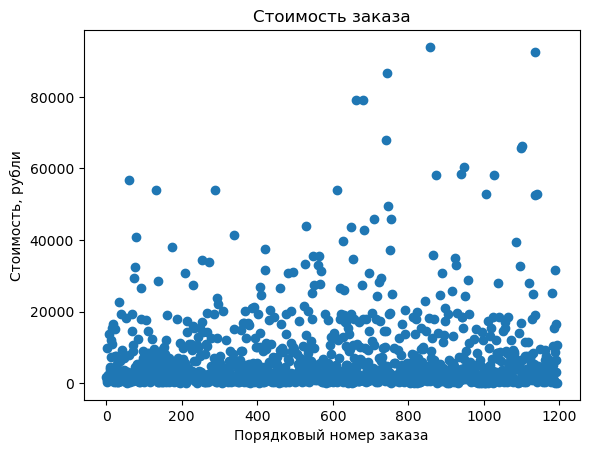

In [39]:
orders_new = orders.query('revenue < 200000')
x_values_new = pd.Series(range(0, len(orders_new['revenue'])))
plt.scatter(x_values_new, orders_new['revenue'])
plt.title('Стоимость заказа')
plt.xlabel('Порядковый номер заказа')
plt.ylabel('Стоимость, рубли');

**Вывод:** Основная часть заказов имеет стоимость до 20 тысяч рублей. Присутствуют особо крупные заказы стоимостью выше 40 тысяч.

### 95-й и 99-й перцентили стоимости заказов

Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [40]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% заказов имеют стоимость выше 28000 рублей, не более 1% - больше 58233.2 рубля.

Обозначим стоимость заказа 28000 рублей как границу для определения аномальных заказов.

In [41]:
revenue_limit = np.percentile(orders['revenue'], [95, 99])[0]

### Статистическая значимость различий в среднем количестве заказов на посетителя  между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Сформулируем нулевую и альтернативную гипотезы:
```
H_0: Среднее количество заказов на посетителя в группе B по «сырым» данным = среднее количество заказов на посетителя в группе A по «сырым» данным
H_a: Среднее количество заказов на посетителя в группе B по «сырым» данным ≠ среднее количество заказов на посетителя в группе A по «сырым» данным
alpha = 0.05
```

In [42]:
# количество посетителей по дням для группы A
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# количество посетителей по дням для группы B
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# найдём число заказов для каждого клиента группы A с хотя бы одной покупкой
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

# найдём число заказов для каждого клиента группы B с хотя бы одной покупкой
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 

# в переменных sampleA и sampleB для групп A и B пользователям с заказами будет соответствовать число их заказов,
# а пользователям без заказов — нули
sampleA = pd.concat(
    [ordersByUsersA['orders'], 
    pd.Series(0, index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
    name='orders')],axis=0
)

sampleB = pd.concat(
    [ordersByUsersB['orders'],
    pd.Series(0, index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
    name='orders')],axis=0
)

# посчитаем статистическую значимость различия среднего количества заказов по тесту Манна-Уитни
# выведем p-value
display('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))
# выведем относительное различие в среднем между группами
display(
    'Относительное различие в среднем количестве заказов на посетителя между группами по «сырым» данным: {0:.3f}'
    .format(sampleB.mean() / sampleA.mean() - 1)
)

'p-value: 0.017'

'Относительное различие в среднем количестве заказов на посетителя между группами по «сырым» данным: 0.138'

**Вывод:**

P-value меньше 0.05, поэтому нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем.
Относительный прирост среднего числа заказов на посетителя группы B к группе A по сырым данным равен 13.8%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем нулевую и альтернативную гипотезы:
```
H_0: Средний чек заказа в группе B по «сырым» данным = средний чек заказа в группе A по «сырым» данным
H_a: Средний чек заказа в группе B по «сырым» данным ≠ средний чек заказа в группе A по «сырым» данным
alpha = 0.05
```

In [43]:
display(
    'p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
     orders[orders['group']=='B']['revenue'])[1])
)

display(
    'Относительное различие в среднем чеке заказа на посетителя между группами по «сырым» данным: {0:.3f}'
    .format(orders[orders['group']=='B']['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean() - 1)
)

'p-value: 0.729'

'Относительное различие в среднем чеке заказа на посетителя между группами по «сырым» данным: 0.259'

**Вывод:**

P-value значительно больше 0.05 - не отвергаем гипотезу о равенстве средних чеков групп. Но относительный прирост среднего чека группы B к группе A по сырым данным равен 25.9% - такая существенная разница при отсутствии статистической значимости указывает на сильное влияние аномальных данных, ниже рассмотрим метрики без них.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Для начала выделим пользователей с количеством заказов больше 4 (99-й перцентиль) и стоимостью заказов выше 28000 рублей (95-й перцентиль).

In [44]:
# выделяем пользователей с большим количеством заказов
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > ordersByUsers_limit]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > ordersByUsers_limit]['visitor_id']
    ],
    axis=0
)

# выделяем пользователей с дорогими заказами
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_limit]['visitor_id']

# объединяем аномальных пользователей, удаляем дубликаты и сортируем по возрастанию
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers.head(5)

1099    148427295
928     204675465
684     358944393
648     382846391
1189    393266494
Name: visitor_id, dtype: int64

In [45]:
# количество пользователей с аномальным количеством заказов или аномальной суммой заказа
abnormalUsers.shape[0]

59

In [46]:
# доля аномальных пользователей в сырых данных
abnormalUsers.shape[0] / orders['visitor_id'].nunique() * 100

5.722599418040737

Аномальные пользователи составляют 5.7% от общего числа. Это допустимое значение, поэтому смело можно исключить их.

In [47]:
# исключаем аномальных пользователей группы A из сырых данных о количестве заказов на пользователя
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders'
        )
    ],
    axis=0
)

# исключаем аномальных пользователей группы B из сырых данных о количестве заказов на пользователя
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders'
        )
    ],
    axis=0
)

Сформулируем нулевую и альтернативную гипотезы:

```
H_0: Среднее количество заказов на посетителя в группе B по «очищенным» данным = среднее количество заказов на посетителя в группе A по «очищенным» данным
H_a: Среднее количество заказов на посетителя в группе B по «очищенным» данным ≠ среднее количество заказов на посетителя в группе A по «очищенным» данным
alpha = 0.05
```

In [48]:
display('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
display(
    'Относительный прирост среднего количества заказов на посетителя между очищенными группами: {0:.3f}'
    .format(sampleBFiltered.mean()/sampleAFiltered.mean() - 1)
)

'p-value: 0.018'

'Относительный прирост среднего количества заказов на посетителя между очищенными группами: 0.145'

**Вывод:**

P-value ниже 0.05, поэтому нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный прирост среднего числа заказов на посетителя группы B к группе A после очистки данных от аномальных значений увеличился на 0.7 процентных пунктов и составил 14.5%.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Сформулируем нулевую и альтернативную гипотезы:
```
H_0: Средний чек заказа в группе B по «очищенным» данным = средний чек заказа в группе A по «очищенным» данным
H_a: Средний чек заказа в группе B по «очищенным» данным ≠ средний чек заказа в группе A по «очищенным» данным
alpha = 0.05
```

In [49]:
# отфильтруем данные по заказам для групп A и B от аномальных пользователей
ordersAFiltered = orders[
    np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers))
    )
]

ordersBFiltered = orders[
    np.logical_and(
        orders['group'] == 'B',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers))
    )
]

display(
    'p-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            ordersAFiltered['revenue'],
            ordersBFiltered['revenue']
        )[1]
    )
)

display(
    'Относительный прирост среднего чека очищенной группы B: {0:.3f}'.format(
        ordersBFiltered['revenue'].mean() / ordersAFiltered['revenue'].mean() - 1
    )
)

'p-value: 0.961'

'Относительный прирост среднего чека очищенной группы B: -0.014'

**Вывод:**
P-value значительно больше 0.05 - не отвергаем гипотезу о равенстве средних чеков групп. Относительный прирост среднего чека группы B к группе A составляет -1.4%. После устранения аномалий явно видно, что сильного изменения среднего чека не наблюдается.

## Вывод

Результаты A/B-теста:

- График различия в среднем количестве заказов на посетителя между группами сообщает, что результаты группы B лучше группы A: прирост выровнялся на уровне примерно 14% и имеет тенденцию к росту.
- График различия среднего чека сильно скачет, что говорит об аномалиях.
- По сырым данным средний чек группы B выше группы A на 25.9%, но после удаления аномалий средние чеки групп сравнялись.
- Есть статистически значимое различие в среднем количестве заказов на посетителя между группами как по сырым данным (13.8%), так и после фильтрации аномалий (14.5%).

Исходя из результатов принимаем решение `остановить тест и зафиксировать победу группы B` - среднее количество заказов на посетителя увеличилось на 14.5% при том же среднем чеке, что может привести к увеличению выручки интернет-магазина.